# This jupyter mainly reproduces the paper's BSVAR-based RUL prediction approach(基于BSVAR的RUL预测方法)
# The model structure is shown as:
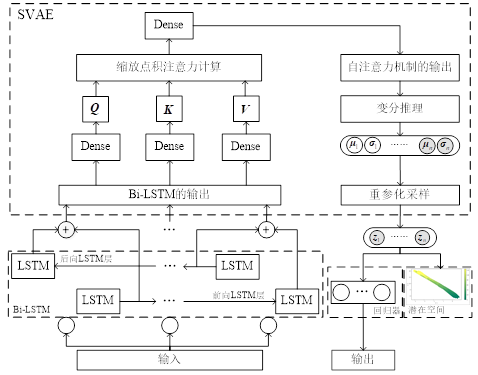

In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Dropout
import utils

In [2]:
dataset = "FD001"

sensors = ['s_{}'.format(i + 1) for i in range(0, 21)]
# windows length
sequence_length = 25
# smoothing intensity
alpha = 0.1
# max RUL
threshold = 125

x_train, y_train, x_val, y_val, x_test, y_test = utils.get_data(dataset, sensors, sequence_length, alpha, threshold)

E:\study\复现资料\RUL-RVE\SIMPAC-2022-58-main\utils.py:60: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df[sensors] = df.groupby('unit_nr')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean()).reset_index(level=0,
E:\study\复现资料\RUL-RVE\SIMPAC-2022-58-main\utils.py:60: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., grou

In [3]:
# Setup the network parameters:
timesteps = x_train.shape[1]
input_dim = x_train.shape[2]
intermediate_dim = 300
batch_size = 256
latent_dim = 2
epochs = 10
# used to mask values in sequences with less than 30 cycles until 30 is reached
masking_value = -99

In [4]:
class Sampling(keras.layers.Layer):
    """Uses (z_mean, sigma) to sample z, the vector encoding an engine trajetory."""
    def call(self, inputs):
        mu, sigma = inputs
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mu + tf.exp(0.5 * sigma) * epsilon

In [5]:
class TimeSelfAttention(tf.keras.layers.Layer):
    def __init__(self,timesteps=timesteps,input_dim=input_dim,num_heads=1):
        """
        num_heads 设置为1则为普通的时间步自注意力机制
        """
        super(TimeSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.timesteps = timesteps
        self.input_dim = input_dim

        assert input_dim % num_heads == 0, "Input dimension must be divisible by the number of heads."

        self.query_dense = tf.keras.layers.Dense(units=input_dim)
        self.key_dense = tf.keras.layers.Dense(units=input_dim)
        self.value_dense = tf.keras.layers.Dense(units=input_dim)
        self.combine_heads = tf.keras.layers.Dense(units=input_dim)

    def call(self, lstm_out_bidirectional):
        # Reshape inputs
        batch_size = tf.shape(lstm_out_bidirectional)[0]
        queries = self.query_dense(lstm_out_bidirectional)
        keys = self.key_dense(lstm_out_bidirectional)
        values = self.value_dense(lstm_out_bidirectional)

        # Split heads
        queries = tf.reshape(queries, [batch_size, self.timesteps, self.num_heads, self.head_dim])#重塑数据形状
        keys = tf.reshape(keys, [batch_size, self.timesteps, self.num_heads, self.head_dim])
        values = tf.reshape(values, [batch_size, self.timesteps, self.num_heads, self.head_dim])

        # Calculate self-attention scores
        attention_scores = tf.matmul(queries, keys, transpose_b=True)
        attention_scores = attention_scores / tf.math.sqrt(tf.cast(self.head_dim, tf.float32))#进行放缩操作
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)

        # Attend to values
        attended_values = tf.matmul(attention_scores, values)
        attended_values = tf.reshape(attended_values, [batch_size, self.timesteps, self.input_dim])

        # Combine heads
        attended_values = self.combine_heads(attended_values)
        
        return tf.reduce_mean(attended_values, axis=1)


In [6]:
# ----------------------- Encoder -----------------------
inputs = Input(shape=(timesteps, input_dim,), name='encoder_input')


#mask = Masking(mask_value=masking_value)(inputs)

# LSTM encoding
lstm_out = LSTM(intermediate_dim, return_sequences=True)(inputs)
lstm_out_layer = LSTM(intermediate_dim, return_sequences=True)  # 添加LSTM层
lstm_out_bidirectional = Bidirectional(lstm_out_layer, merge_mode='sum')(lstm_out)  # 使用LSTM层作为参数


attention_out = TimeSelfAttention(timesteps=lstm_out_bidirectional.shape[1],
                                  input_dim=lstm_out_bidirectional.shape[2])(lstm_out_bidirectional)


# VAE Z layer
mu = Dense(latent_dim)(attention_out)
sigma = Dense(latent_dim)(attention_out)


z = Sampling()([mu, sigma])


# Instantiate the encoder model:
encoder = keras.Model(inputs, [mu, sigma, z], name='encoder')

print(encoder.summary())
# -------------------------------------------------------

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 25, 21)]     0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 25, 300)      386400      ['encoder_input[0][0]']          
                                                                                                  
 bidirectional (Bidirectional)  (None, 25, 300)      1442400     ['lstm[0][0]']                   
                                                                                                  
 time_self_attention (TimeSelfA  (None, 300)         361200      ['bidirectional[0][0]']          
 ttention)                                                                                  

In [7]:
# ----------------------- Regressor --------------------
reg_latent_inputs = Input(shape=(latent_dim), name='z_sampling_reg')


reg_intermediate2 = Dense(200,activation='relu')(reg_latent_inputs)
reg_dropout = Dropout(0.5)(reg_intermediate2)
reg_outputs = Dense(1,name='reg_output')(reg_dropout)
# Instantiate the classifier model:
regressor = keras.Model(reg_latent_inputs, reg_outputs, name='regressor')
print(regressor.summary())
# -------------------------------------------------------

Model: "regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling_reg (InputLayer)  [(None, 2)]              0         
                                                                 
 dense_6 (Dense)             (None, 200)               600       
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 reg_output (Dense)          (None, 1)                 201       
                                                                 
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
class CLT_VAR(keras.Model):
    def __init__(self, encoder, regressor, **kwargs):
        super(CLT_VAR, self).__init__(**kwargs)
        self.encoder = encoder
        self.regressor = regressor
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.reg_loss_tracker = keras.metrics.Mean(name="reg_loss")
        

    @property
    def metrics(self):
        self.total_loss_tracker,
        self.kl_loss_tracker,
        self.reg_loss_tracker,
            

    def train_step(self, data):
        x, target_x = data
        with tf.GradientTape() as tape:
            # kl loss
            mu, sigma, z = self.encoder(x)
            kl_loss = -0.5 * (1 + sigma - tf.square(mu) - tf.exp(sigma))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            # Regressor
            reg_prediction = self.regressor(z)
            reg_loss = tf.reduce_mean(
                keras.losses.mse(target_x, reg_prediction)
            )
            total_loss = kl_loss + reg_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reg_loss_tracker.update_state(reg_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


    def test_step(self, data):
        x, target_x = data

        # kl loss
        mu, sigma, z = self.encoder(x)
        kl_loss = -0.5 * (1 + sigma - tf.square(mu) - tf.exp(sigma))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        # Regressor
        reg_prediction = self.regressor(z)
        reg_loss = tf.reduce_mean(
            keras.losses.mse(target_x, reg_prediction)
        )
        total_loss = kl_loss + reg_loss

        return {
            "loss": total_loss,
            "kl_loss": kl_loss,
        }


In [9]:
class save_latent_space_viz(Callback):
    def __init__(self, model, data, target):
        self.model = model
        self.data = data
        self.target = target

    def on_train_begin(self, logs={}):
        self.best_val_loss = 100000

    def on_epoch_end(self, epoch, logs=None):
        encoder = self.model.layers[0]
        if logs.get('val_loss') < self.best_val_loss:
            self.best_val_loss = logs.get('val_loss')
            viz_latent_space(encoder, self.data, self.target, epoch, True, False)


In [12]:

def get_callbacks(model, data, target):
    model_callbacks = [
        EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15),
        ModelCheckpoint(filepath='FD001图片/checkpoint', monitor='val_loss', mode='min', verbose=1,
                        save_best_only=True, save_weights_only=True)
    ]
    return model_callbacks


In [15]:
CLT_VAR = CLT_VAR(encoder, regressor)
model_callbacks = get_callbacks(CLT_VAR, x_train, y_train)

In [16]:
#For convenience randomly read one of the previous training parameters, namely checkpoint
CLT_VAR.load_weights('FD001图片\\最优/checkpoint')

In [ ]:
#If model training is needed, remove the annotations
"""
CLT_VAR.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
History = CLT_VAR.fit(x_train, y_train,epochs=epochs,validation_data=(x_val, y_val), batch_size=batch_size,callbacks=model_callbacks)
"""

In [ ]:
#Print the loss function
"""
def plotTrainHistory(model,title=' '):
    plt.grid(linestyle="--")
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper right')
    
    plt.show()
    
print(History.history.keys())
plotTrainHistory(History)
"""

In [17]:
def viz_latent_space(encoder, data, targets=[], epoch='Final', show=True):
    z, _, _ = encoder.predict(data)

    return z



In [18]:
train_mu = viz_latent_space(CLT_VAR.encoder, np.concatenate((x_train, x_val)), np.concatenate((y_train, y_val)))
test_mu = viz_latent_space(CLT_VAR.encoder, x_test, y_test)


4/4 [==============================] - 0s 89ms/step


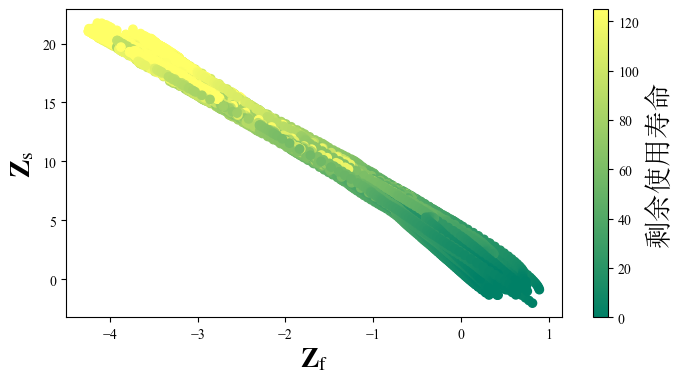

In [19]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 4))
cmap = plt.cm.get_cmap("summer")
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'
scatter = plt.scatter(train_mu[:, 0], train_mu[:, 1], c=np.concatenate((y_train, y_val)), cmap=cmap)
plt.xlabel(r'$\mathit{\mathbf{Z}}_\mathrm{f}$', fontsize=20, fontfamily='Times New Roman')
plt.ylabel(r'$\mathit{\mathbf{Z}}_\mathrm{s}$', fontsize=20, fontfamily='Times New Roman')

cbar = plt.colorbar(scatter)
cbar.set_label('剩余使用寿命', fontsize=20, fontname='SimSun')  # 设置颜色条标签为 "剩余受用寿命" 并使用宋体表示
plt.show()


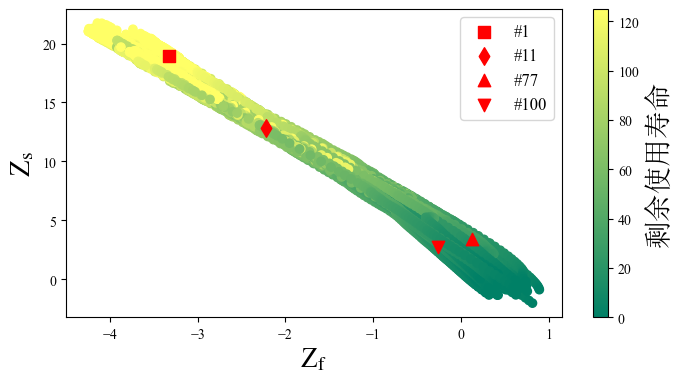

In [20]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 4))
cmap = plt.cm.get_cmap("summer")
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

scatter = plt.scatter(train_mu[:, 0], train_mu[:, 1], c=np.concatenate((y_train, y_val)), cmap=cmap)
plt.scatter(test_mu[0, 0], test_mu[0, 1], marker='s', s=80, color="red", label='#1')
plt.scatter(test_mu[10, 0], test_mu[10, 1], marker='d', s=80, color="red", label='#11')
plt.scatter(test_mu[76, 0], test_mu[76, 1], marker='^', s=80, color="red", label='#77')
plt.scatter(test_mu[99, 0], test_mu[99, 1], marker='v', s=80, color="red", label='#100')
plt.xlabel(r'Z$_\mathrm{f}$', fontsize=20, fontfamily='Times New Roman')
plt.ylabel(r'Z$_\mathrm{s}$', fontsize=20, fontfamily='Times New Roman')

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array(np.concatenate((y_train, y_val)))
cbar = plt.colorbar(scatter)
cbar.set_label('剩余使用寿命', fontsize=20, fontname='SimSun')  # 设置颜色条标签为 "剩余受用寿命" 并使用宋体表示
#cbar.set_mappable(sm)
plt.legend(fontsize=12)
plt.show()


In [21]:
# Evaluate
y_hat_train = CLT_VAR.regressor.predict(train_mu)
y_hat_test = CLT_VAR.regressor.predict(test_mu)
y_hat_test_min = np.clip(y_hat_test,0,125)
utils.evaluate(np.concatenate((y_train, y_val)), y_hat_train, 'train')
RMSE=utils.evaluate(y_test, y_hat_test, 'test')
score=utils.score(y_test, y_hat_test)


4/4 [==============================] - 0s 1ms/step
train set RMSE:13.765728950500488, R2:0.8917307020753662
test set RMSE:14.528611660607792, R2:0.8685566793121171
score:  291.94901943206787
